In [42]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import numpy as np

def get_segmented_objects(mask, min_size=100):
    # Threshold the mask to obtain a binary image
    ret, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # Perform connected components labeling
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh)


    # Draw separate contours for each connected component
    bounding_boxes = []
    for label in range(1, num_labels):
        # Create a mask for the current label
        label_mask = (labels == label).astype('uint8') * 255

        # Generate contours from the label mask
        contours, hierarchy = cv2.findContours(label_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        contours, _ = cv2.findContours(label_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        boarder = False
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if(x<=10 or x+w>=1023) or (y<=10 or y+h>=1023):
                boarder = True
            if not boarder or w * h >= min_size:
                bounding_boxes.append((x + w/2, y + h/2, w, h))
                boarder = False
    
    return bounding_boxes

def process_image(image_path, mask_path, vis=False):
    image_name = os.path.basename(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    bounding_boxes = get_segmented_objects(mask)
    format = "cx_cy_w_h"
    boxes = []
    data = []
    
    for bbox in bounding_boxes:
        center_x, center_y, width, height = bbox
        boxes.append([center_x,center_y,width,height])
    if bounding_boxes:
        data.append({
                'Image Name': image_name,
                'Image Path': image_path,
                'bbox_coord':boxes,
                'num_patch': len(bounding_boxes),
                'bbox_format':format,
        })
    else:
        data.append({
                'Image Name': image_name,
                'Image Path': image_path,
                'bbox_coord':[],
                'num_patch': 0,
                'bbox_format':format,
        })

    
    if vis:
        if bounding_boxes:
            empty = np.zeros([1024, 1024])
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
            ax1.imshow(empty)
            ax1.set_title('Image')
            ax1.axis('off')
            
            ax2.imshow(mask, cmap='gray')
            ax2.set_title('Mask')
            ax2.axis('off')
            
            for bbox in bounding_boxes:
                center_x, center_y, width, height = bbox
                x = center_x - width/2
                y = center_y - height/2
                rect = plt.Rectangle((x, y), width, height, fill=False, edgecolor='g')
                ax1.add_patch(rect)
        
            plt.show()
    
    return data

def process_images(folder_path, vis=False):
    image_files = os.listdir(folder_path)
    mask_folder = folder_path.replace("images", "masks")
    data = []
    print("threads are starting")
    with ThreadPoolExecutor() as executor:
        results = []
        
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            mask_path = os.path.join(mask_folder, image_file.replace('_image.jpg', '_mask.jpg'))
            
            if not os.path.exists(mask_path):
                continue
            
            result = executor.submit(process_image, image_path, mask_path, vis)
            results.append(result)
        
        for result in results:
            data.extend(result.result())
    
    df = pd.DataFrame(data)
    df.to_csv('segmentation_data.csv', index=False)
    print('Segmentation data saved to segmentation_data.csv')

# Provide the folder path containing the images and masks
folder_path = '/home/humanoid/internalHD/datasets/kidney_patch/train/images_4096/'
process_images(folder_path, vis=False)


threads are starting
Segmentation data saved to segmentation_data.csv


In [2]:
image = cv2.imread('/home/humanoid/internalHD/datasets/kidney_patch/train/0486052bb_001_017_image.jpg')

[ WARN:43@564.985] global loadsave.cpp:244 findDecoder imread_('/home/humanoid/internalHD/datasets/kidney_patch/train/0486052bb_001_017_image.jpg'): can't open/read file: check file path/integrity


In [43]:
df = pd.read_csv("segmentation_data.csv")

In [44]:
df

Image Name  \
0    0486052bb.tiff_index__0_4096_11645_15741__imag...   
1    0486052bb.tiff_index__0_4096_15527_19623__imag...   
2    0486052bb.tiff_index__0_4096_19409_23505__imag...   
3    0486052bb.tiff_index__0_4096_23291_27387__imag...   
4    0486052bb.tiff_index__0_4096_27173_31269__imag...   
..                                                 ...   
328  e79de561c.tiff_index__9708_13804_15440_19536__...   
329  e79de561c.tiff_index__9708_13804_19300_23396__...   
330  e79de561c.tiff_index__9708_13804_22924_27020__...   
331  e79de561c.tiff_index__9708_13804_3860_7956__im...   
332  e79de561c.tiff_index__9708_13804_7720_11816__i...   

                                            Image Path  \
0    /home/humanoid/internalHD/datasets/kidney_patc...   
1    /home/humanoid/internalHD/datasets/kidney_patc...   
2    /home/humanoid/internalHD/datasets/kidney_patc...   
3    /home/humanoid/internalHD/datasets/kidney_patc...   
4    /home/humanoid/internalHD/datasets/kidney_patc...   
..                                                 ...   
328  /home/humanoid/internalHD/datasets/kidney_patc...   
329  /home/humanoid/internalHD/datasets/kidney_patc...   
330  /home/humanoid/internalHD/datasets/kidney_patc...   
331  /home/humanoid/internalHD/datasets/kidney_patc...   
332  /home/humanoid/internalHD/datasets/kidney_patc...   

                                            bbox_coord  num_patch bbox_format  
0    [[31.5, 605.0, 63, 84], [907.0, 611.5, 50, 49]...          6   cx_cy_w_h  
1    [[815.5, 559.0, 103, 78], [521.5, 604.5, 101, ...          7   cx_cy_w_h  
2    [[116.5, 609.5, 57, 35], [947.0, 619.5, 58, 45...          8   cx_cy_w_h  
3    [[480.0, 739.5, 82, 97], [336.5, 858.5, 69, 99...          4   cx_cy_w_h  
4    [[889.5, 667.0, 79, 82], [394.0, 729.0, 80, 84...          6   cx_cy_w_h  
..                                                 ...        ...         ...  
328  [[903.0, 106.5, 100, 103], [663.0, 144.5, 70, ...          9   cx_cy_w_h  
329  [[411.0, 26.5, 112, 53], [926.5, 38.0, 93, 66]...         11   cx_cy_w_h  
330  [[33.5, 38.5, 67, 67], [256.5, 281.0, 93, 88],...          4   cx_cy_w_h  
331  [[678.5, 21.5, 71, 43], [994.0, 16.0, 60, 32],...         11   cx_cy_w_h  
332  [[36.0, 16.0, 72, 32], [204.5, 14.0, 71, 28], ...         17   cx_cy_w_h  

[333 rows x 5 columns]

Image name: /home/humanoid/internalHD/datasets/kidney_patch/train/images_4096/0486052bb.tiff_index__7366_11462_0_4096__image.jpg
[[1005.0, 601.0, 38, 98]]
on boarder


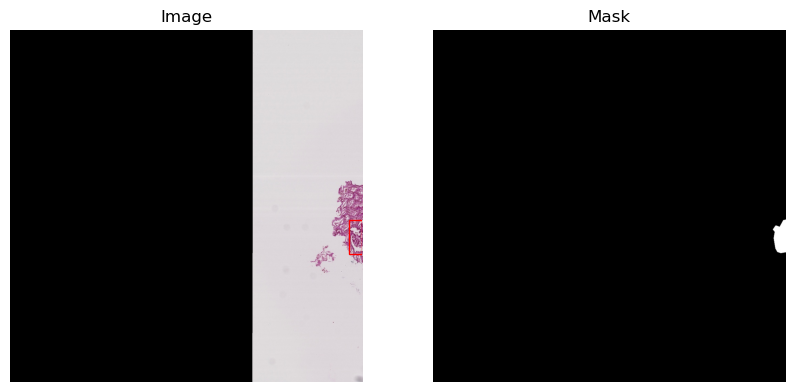

Image name: /home/humanoid/internalHD/datasets/kidney_patch/train/images_4096/cb2d976f4.tiff_index__27175_31271_3811_7907__image.jpg
[[759.5, 47.5, 79, 95], [951.0, 303.0, 98, 112]]
on boarder


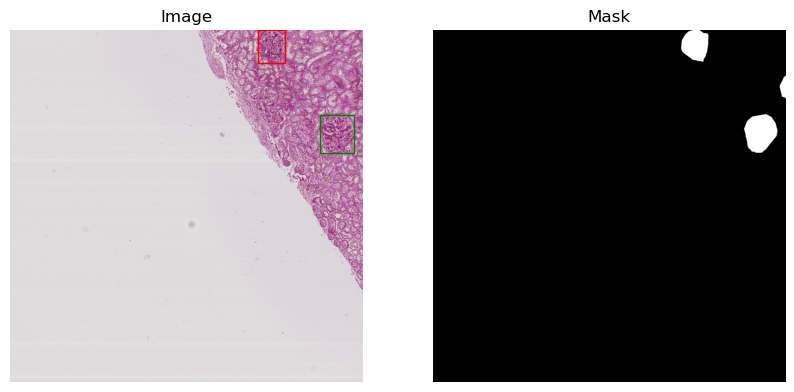

Image name: /home/humanoid/internalHD/datasets/kidney_patch/train/images_4096/afa5e8098.tiff_index__0_4096_25538_29634__image.jpg
[[702.0, 257.0, 198, 124], [257.5, 258.0, 73, 66], [150.5, 288.0, 87, 86], [256.5, 349.5, 111, 107], [321.0, 594.5, 126, 115], [39.0, 660.5, 76, 105], [808.0, 680.5, 94, 93], [143.0, 705.5, 74, 89], [378.5, 749.0, 115, 110], [428.0, 987.0, 134, 74], [305.5, 1005.0, 85, 38]]
on boarder
on boarder
on boarder


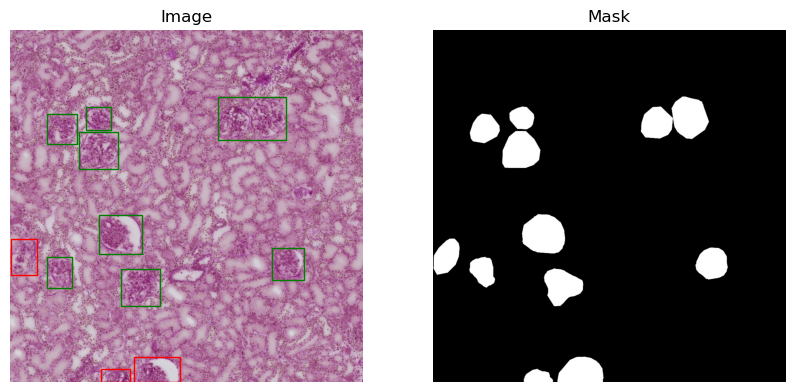

Image name: /home/humanoid/internalHD/datasets/kidney_patch/train/images_4096/8242609fa.tiff_index__15649_19745_11016_15112__image.jpg
[[909.0, 131.5, 94, 139], [810.0, 264.5, 50, 51], [719.0, 277.5, 82, 73], [983.5, 316.5, 69, 67], [145.5, 398.5, 45, 57], [607.0, 436.0, 82, 66], [126.5, 645.5, 79, 75], [1004.5, 654.0, 39, 60], [613.0, 689.0, 68, 64], [223.5, 739.0, 73, 60], [966.0, 798.5, 50, 55], [526.0, 866.5, 74, 65], [22.0, 893.0, 44, 88], [422.0, 909.0, 94, 70], [632.5, 1007.5, 53, 33], [818.5, 1011.0, 69, 26]]
on boarder
on boarder
on boarder
on boarder


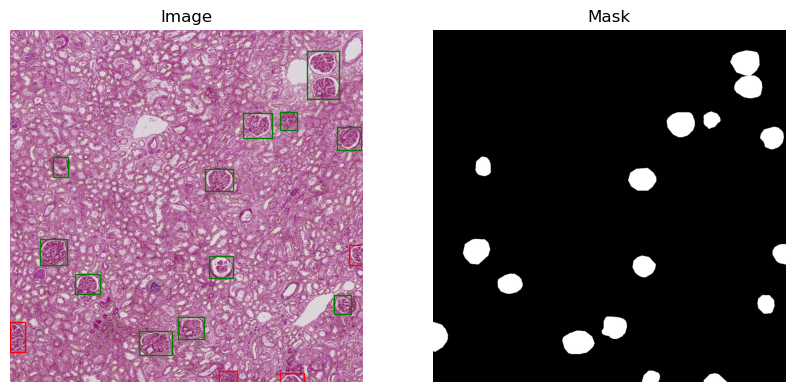

Image name: /home/humanoid/internalHD/datasets/kidney_patch/train/images_4096/8242609fa.tiff_index__19561_23657_33049_37145__image.jpg
[[494.5, 21.0, 67, 42], [317.5, 47.5, 61, 43], [79.0, 89.5, 60, 53], [104.0, 172.0, 62, 62]]
on boarder


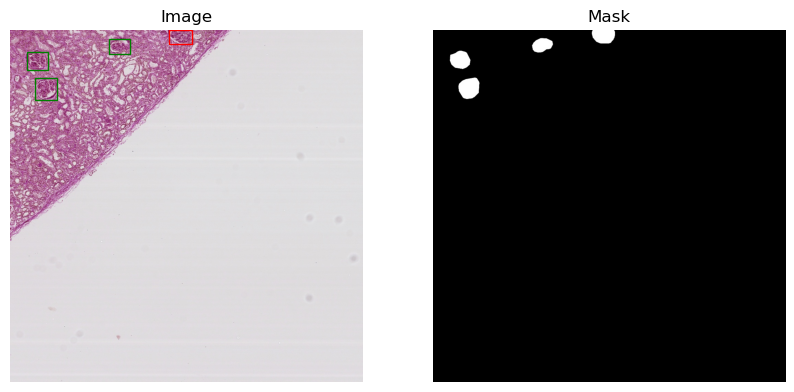

Image name: /home/humanoid/internalHD/datasets/kidney_patch/train/images_4096/8242609fa.tiff_index__19561_23657_14688_18784__image.jpg
[[40.0, 663.5, 64, 55], [934.0, 728.5, 52, 55], [942.5, 841.0, 57, 60], [474.5, 852.0, 69, 76], [77.5, 924.0, 79, 74], [321.5, 944.0, 51, 56], [615.5, 952.0, 73, 72], [895.0, 1011.5, 70, 25]]
on boarder
on boarder


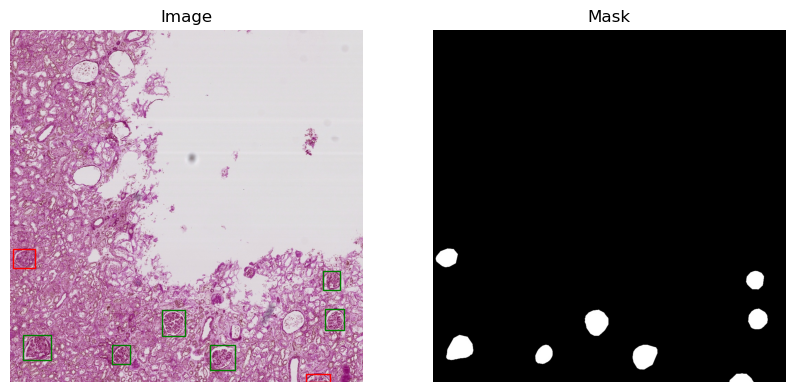

Image name: /home/humanoid/internalHD/datasets/kidney_patch/train/images_4096/b9a3865fc.tiff_index__19559_23655_3675_7771__image.jpg
[[774.0, 474.5, 82, 59], [247.5, 609.0, 65, 72], [761.5, 702.5, 67, 85], [43.0, 824.5, 86, 71], [643.0, 927.0, 76, 76]]
on boarder


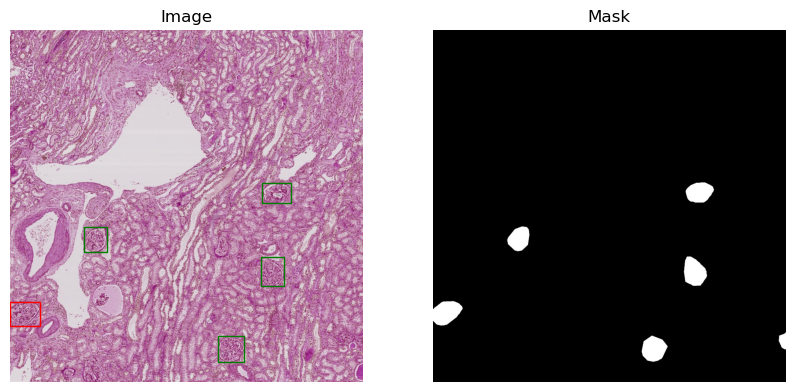

Image name: /home/humanoid/internalHD/datasets/kidney_patch/train/images_4096/b9a3865fc.tiff_index__23471_27567_18376_22472__image.jpg
[[37.0, 27.0, 68, 54], [495.0, 86.0, 62, 64], [308.5, 96.0, 73, 68], [805.0, 147.5, 72, 89], [377.0, 223.0, 56, 68], [436.0, 243.0, 40, 62], [89.0, 302.5, 68, 85], [818.5, 300.5, 61, 69], [894.5, 335.5, 63, 83], [624.0, 370.5, 62, 93], [125.0, 380.5, 66, 81], [781.0, 469.0, 70, 96], [962.0, 518.5, 70, 93], [836.0, 592.0, 72, 98], [218.0, 601.0, 54, 56], [705.0, 682.0, 68, 80], [454.0, 709.5, 52, 69], [139.0, 739.0, 40, 44], [767.0, 752.0, 58, 66], [48.5, 801.0, 75, 88], [908.5, 818.5, 61, 59], [517.0, 871.0, 78, 78], [316.5, 873.0, 71, 66], [852.0, 937.5, 54, 55], [304.5, 1004.5, 85, 39]]
on boarder
on boarder


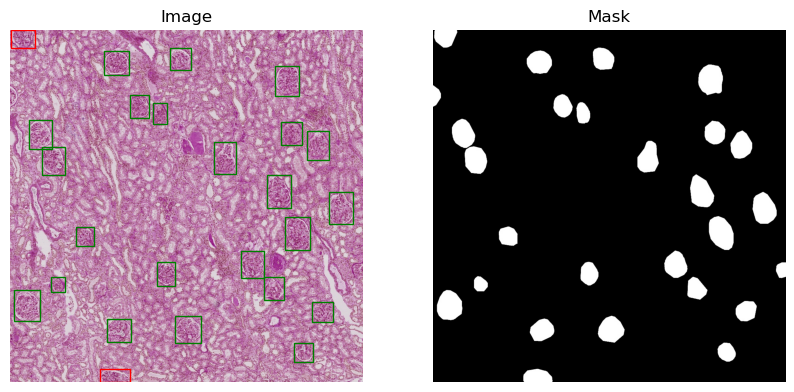

Image name: /home/humanoid/internalHD/datasets/kidney_patch/train/images_4096/afa5e8098.tiff_index__25760_29856_32835_36931__image.jpg
[[937.5, 298.5, 95, 95], [891.0, 1000.0, 118, 48]]
on boarder


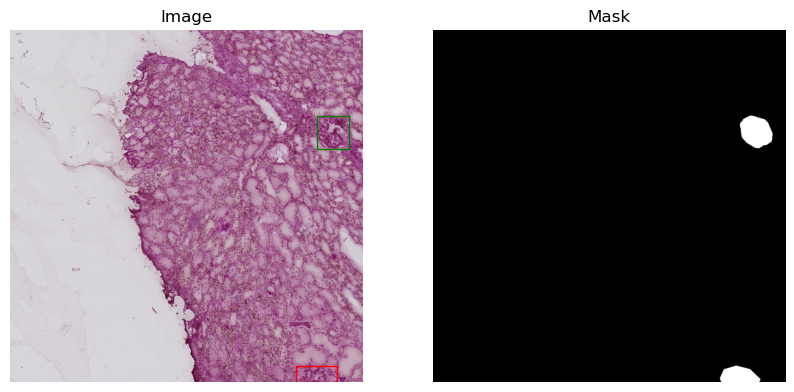

Image name: /home/humanoid/internalHD/datasets/kidney_patch/train/images_4096/afa5e8098.tiff_index__7360_11456_0_4096__image.jpg
[[879.5, 36.0, 73, 72], [1002.5, 269.0, 43, 92], [997.0, 390.5, 54, 101]]
on boarder
on boarder
on boarder


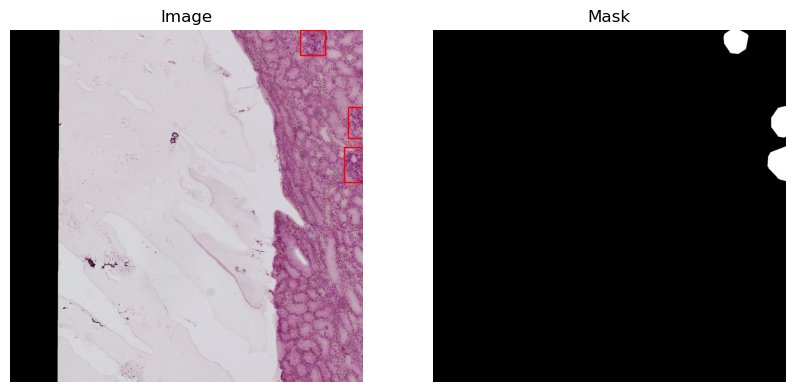

Image name: /home/humanoid/internalHD/datasets/kidney_patch/train/images_4096/afa5e8098.tiff_index__29440_33536_36483_40579__image.jpg
[[587.0, 55.5, 98, 111], [19.0, 109.5, 38, 89], [187.5, 154.5, 97, 95], [635.0, 278.5, 68, 77], [62.5, 283.5, 103, 71]]
on boarder
on boarder


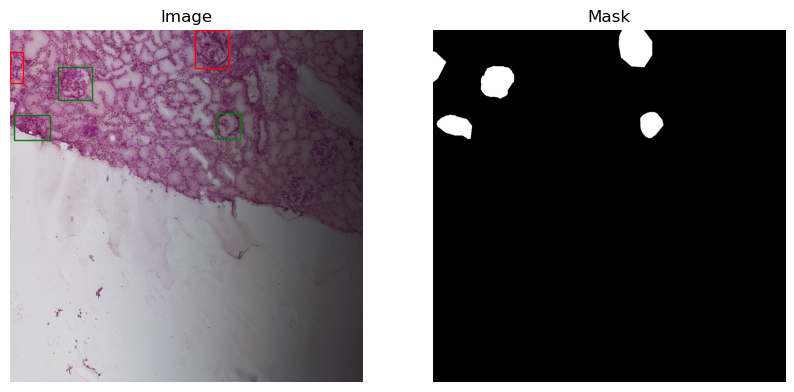

Image name: /home/humanoid/internalHD/datasets/kidney_patch/train/images_4096/afa5e8098.tiff_index__3680_7776_18241_22337__image.jpg
[[285.5, 75.5, 145, 117], [820.5, 146.5, 75, 69], [688.5, 162.0, 89, 94], [698.5, 278.5, 71, 91], [27.5, 567.5, 55, 53], [564.0, 599.0, 78, 104], [167.0, 724.5, 84, 79], [56.0, 827.5, 112, 127], [603.5, 926.5, 59, 69], [605.5, 990.5, 71, 67]]
on boarder
on boarder
on boarder


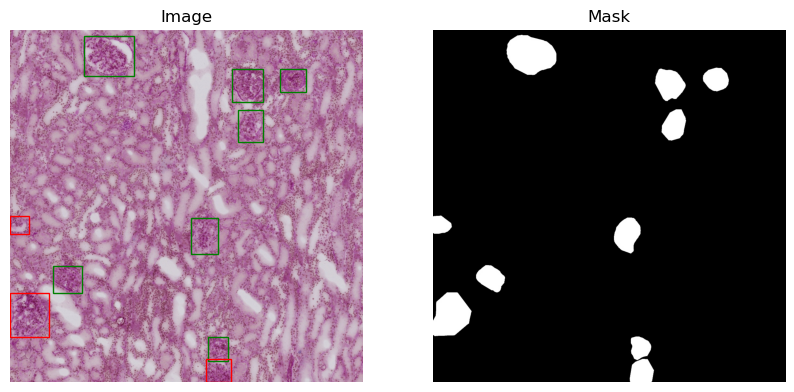

Image name: /home/humanoid/internalHD/datasets/kidney_patch/train/images_4096/aaa6a05cc.tiff_index__0_4096_3253_7349__image.jpg
[[495.0, 508.0, 68, 80], [794.5, 523.5, 63, 59], [864.5, 541.0, 81, 62], [444.5, 765.0, 73, 68], [728.5, 980.5, 83, 73]]


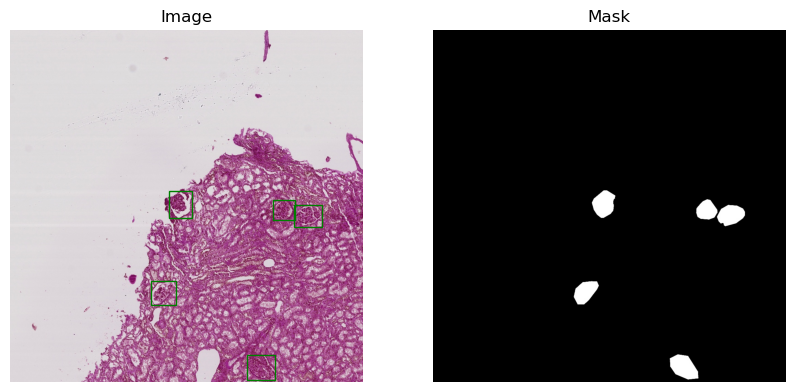

Image name: /home/humanoid/internalHD/datasets/kidney_patch/train/images_4096/aaa6a05cc.tiff_index__14388_18484_3253_7349__image.jpg
[[191.5, 29.0, 73, 58], [350.0, 120.0, 74, 66], [24.0, 130.0, 48, 72], [126.0, 175.0, 52, 58], [230.5, 177.0, 43, 58], [585.5, 188.5, 45, 57], [501.0, 195.0, 58, 50], [482.5, 269.5, 49, 57], [325.0, 311.0, 40, 52]]
on boarder
on boarder


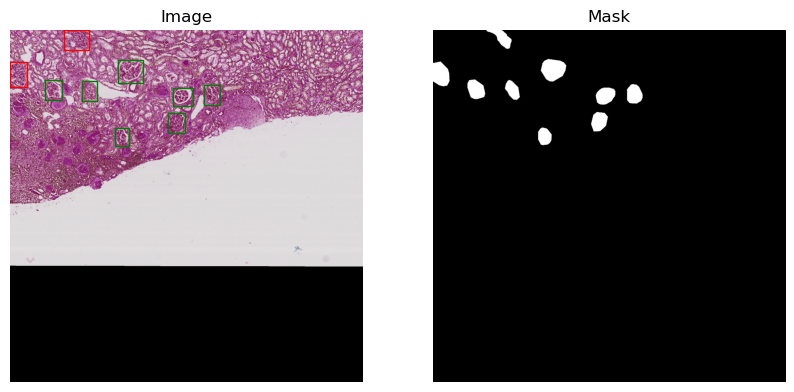

Image name: /home/humanoid/internalHD/datasets/kidney_patch/train/images_4096/afa5e8098.tiff_index__3680_7776_14593_18689__image.jpg
[[476.0, 17.5, 90, 35], [745.0, 138.0, 124, 104], [641.5, 294.5, 105, 103], [705.0, 495.5, 70, 65], [928.5, 567.5, 77, 53], [722.0, 615.0, 54, 68], [154.0, 747.0, 116, 116], [962.5, 827.5, 123, 127], [43.0, 887.0, 86, 106], [820.0, 928.0, 94, 118], [118.5, 1002.0, 91, 44]]
on boarder
on boarder
on boarder
on boarder


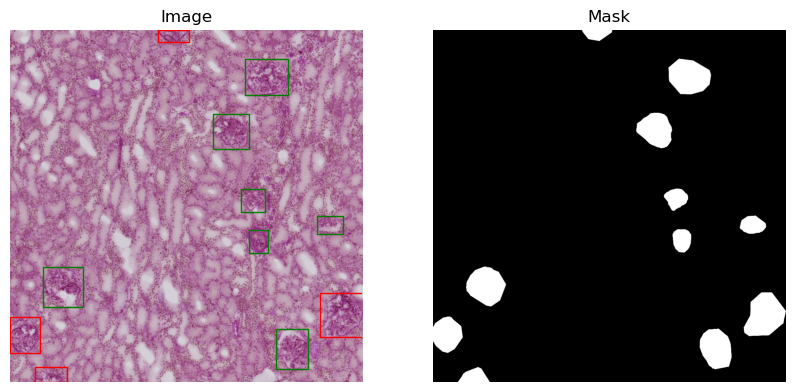

Image name: /home/humanoid/internalHD/datasets/kidney_patch/train/images_4096/0486052bb.tiff_index__21688_25784_7763_11859__image.jpg
[[392.5, 34.0, 81, 68], [940.5, 14.0, 59, 28], [371.0, 77.0, 50, 36], [738.0, 138.0, 74, 44], [418.0, 229.0, 88, 60]]
on boarder
on boarder


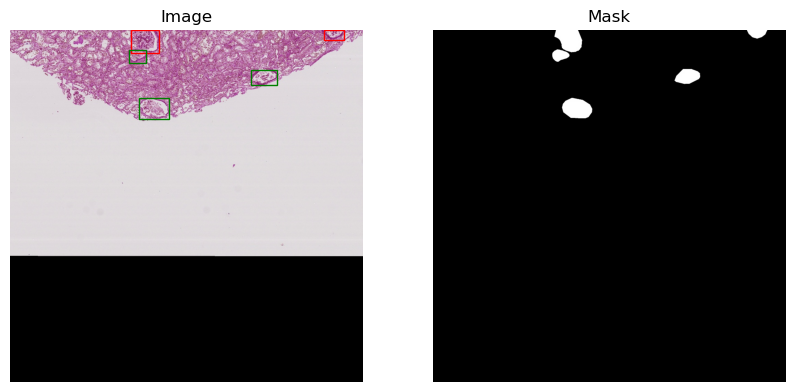

Image name: /home/humanoid/internalHD/datasets/kidney_patch/train/images_4096/afa5e8098.tiff_index__7360_11456_36483_40579__image.jpg
[[295.0, 177.0, 130, 136], [867.5, 338.5, 131, 125], [692.0, 336.5, 96, 85], [101.5, 387.5, 137, 141]]


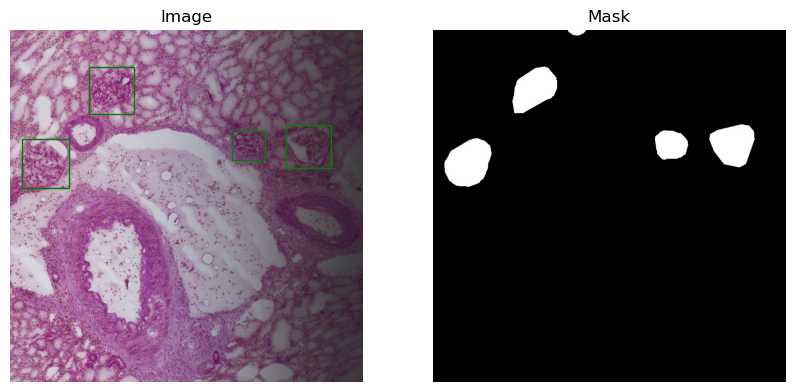

Image name: /home/humanoid/internalHD/datasets/kidney_patch/train/images_4096/afa5e8098.tiff_index__7360_11456_21890_25986__image.jpg
[[343.0, 25.0, 96, 50], [449.0, 13.0, 96, 26], [289.5, 177.0, 113, 100], [411.5, 246.0, 161, 88], [151.5, 311.5, 83, 81], [365.5, 408.5, 149, 91], [421.0, 508.0, 104, 88], [61.5, 533.5, 119, 93], [301.0, 534.0, 144, 60], [46.0, 710.0, 92, 82]]
on boarder
on boarder
on boarder
on boarder


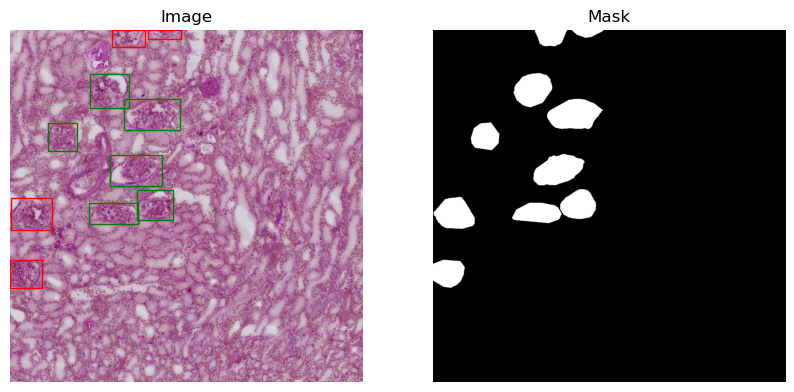

Image name: /home/humanoid/internalHD/datasets/kidney_patch/train/images_4096/8242609fa.tiff_index__3912_8008_18360_22456__image.jpg
[[159.5, 145.0, 37, 36], [44.0, 422.0, 86, 78], [139.0, 576.5, 74, 69], [179.0, 637.5, 74, 71], [37.5, 805.5, 75, 75], [244.0, 846.0, 84, 66], [112.5, 890.0, 41, 48], [26.0, 906.5, 52, 67], [444.0, 956.5, 58, 65]]
on boarder
on boarder
on boarder


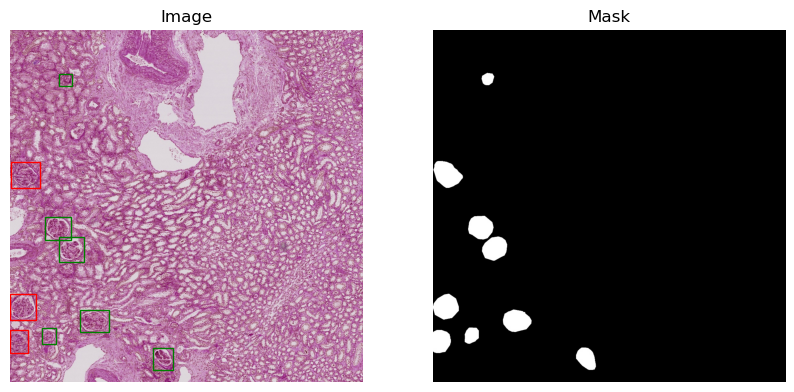

Image name: /home/humanoid/internalHD/datasets/kidney_patch/train/images_4096/afa5e8098.tiff_index__0_4096_36483_40579__image.jpg
[[519.5, 307.0, 113, 90], [982.5, 385.5, 83, 109], [356.5, 495.0, 115, 100], [468.0, 518.0, 94, 92], [930.0, 575.5, 98, 83], [215.5, 727.5, 125, 115], [55.5, 1002.5, 95, 43]]
on boarder
on boarder


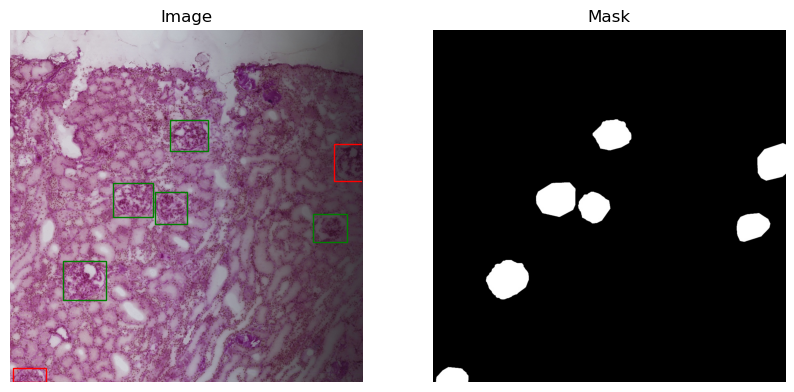

Image name: /home/humanoid/internalHD/datasets/kidney_patch/train/images_4096/b2dc8411c.tiff_index__0_4096_3907_8003__image.jpg
[[992.0, 592.0, 64, 74], [790.5, 606.0, 71, 64], [391.0, 646.0, 74, 72], [728.0, 644.5, 58, 49], [365.5, 796.0, 131, 130], [972.0, 762.0, 56, 64], [746.0, 776.5, 58, 51], [241.5, 866.0, 81, 84], [22.5, 950.0, 45, 60], [766.5, 986.5, 67, 61]]
on boarder
on boarder


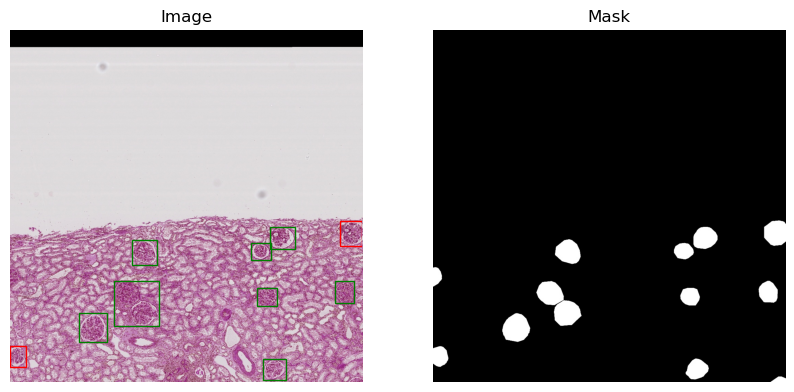

Image name: /home/humanoid/internalHD/datasets/kidney_patch/train/images_4096/e79de561c.tiff_index__6472_10568_11580_15676__image.jpg
[[417.0, 23.0, 82, 46], [728.0, 156.0, 88, 94], [960.5, 186.5, 87, 119], [249.0, 177.0, 80, 96], [635.5, 318.5, 75, 95], [976.5, 398.5, 95, 101], [327.0, 464.5, 98, 95], [212.5, 814.0, 87, 100], [643.0, 888.5, 104, 111]]
on boarder
on boarder


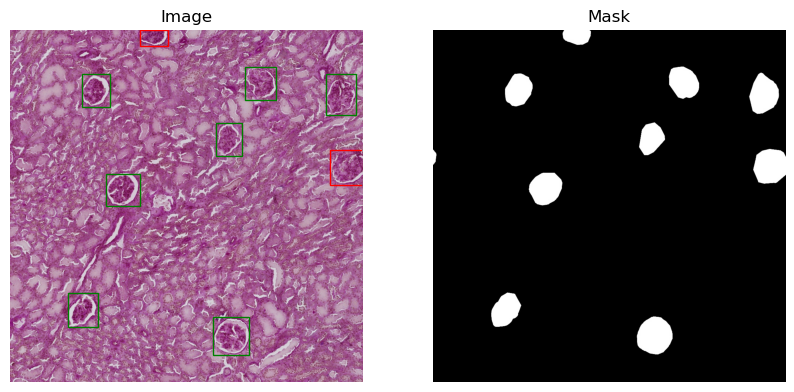

In [45]:
counter = 0
# np.random.seed(42)
samples = df.sample(100)

def is_bounding_box_on_border(x_center, y_center, width, height, image_width=1024, image_height=1024):
    half_width = width / 2
    half_height = height / 2

    if x_center <= half_width or x_center >= image_width - half_width:
        if y_center <= half_height or y_center >= image_height - half_height:
            return "On the border"
    
    return "Not on the border"


for i, image_name in enumerate(samples["Image Path"].values):
    boxes = eval(samples.iloc[i]["bbox_coord"])
    
    if len(boxes) > 0:
        print("Image name:", image_name)
        image = cv2.imread(image_name)
        mask = cv2.imread(image_name.replace("images","masks").replace("_image","_mask"))
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax1.set_title('Image')
        ax1.axis('off')
        
        ax2.imshow(mask)
        ax2.set_title('Mask')
        ax2.axis('off')
        
        print(boxes)
        corner = False
        for bbox in boxes:
            center_x, center_y, width, height = bbox
            c = 'g'
            if((center_x-width//2)<=10 or (center_x-width//2)+width>=1023) or ((center_y-height//2)<=10 or (center_y-height//2)+height>=1023):
                print("on boarder")
                c = 'red'
                corner = True
            
            if corner != True or width*height>1000:
                x = center_x - width // 2
                y = center_y - height // 2
                rect = plt.Rectangle((x, y), width, height, fill=False, edgecolor=c)
                ax1.add_patch(rect)
                corner=False
        
        plt.show()
        
        if counter > 20:
            break
        
        counter += 1


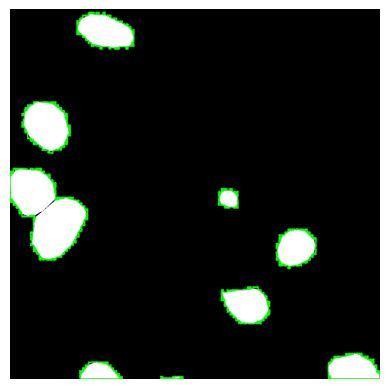

In [15]:
import cv2
import matplotlib.pyplot as plt

# Read the segmentation mask
mask = cv2.imread('/home/humanoid/internalHD/datasets/kidney_patch/train/masks/2f6ecfcdf_012_035_mask.jpg', 0)  # Read as grayscale

# Generate contours from the mask
contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a blank image for drawing contours
contour_image = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

# Draw contours on the image
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

# Display the image with contours using Matplotlib
plt.imshow(contour_image)
plt.axis('off')
plt.show()


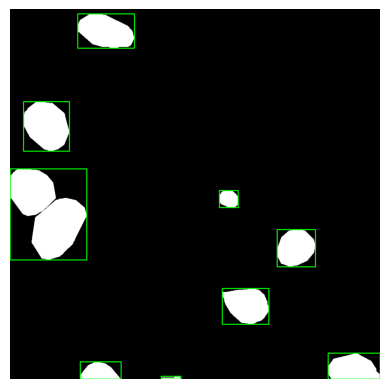

In [12]:
import cv2
import matplotlib.pyplot as plt

# Read the segmentation mask
mask = cv2.imread('/home/humanoid/internalHD/datasets/kidney_patch/train/masks/2f6ecfcdf_012_035_mask.jpg', 0)  # Read as grayscale

# Threshold the mask to obtain a binary image
ret, thresh = cv2.threshold(mask, 15, 255, cv2.THRESH_BINARY)

# Perform connected components labeling
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh)

# Create a blank image for drawing bounding boxes
bbox_image = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

# Draw bounding boxes for each connected component
for label in range(1, num_labels):
    # Create a mask for the current label
    label_mask = (labels == label).astype('uint8') * 255

    # Generate contours from the label mask
    contours, hierarchy = cv2.findContours(label_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate the bounding rectangle for each contour
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        # Draw the bounding box on the image
        cv2.rectangle(bbox_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the image with bounding boxes using Matplotlib
plt.imshow(bbox_image)
plt.axis('off')
plt.show()


In [21]:
samples[samples=="/home/humanoid/internalHD/datasets/kidney_patch/train/images/b9a3865fc_046_036_image.jpg"].dropna(how='all')

Image Name                                         Image Path  \
44881        NaN  /home/humanoid/internalHD/datasets/kidney_patc...   

      bbox_coord  num_patch bbox_format  
44881        NaN        NaN         NaN

In [24]:
bbox = samples[samples["Image Path"]=="/home/humanoid/internalHD/datasets/kidney_patch/train/images/b9a3865fc_046_036_image.jpg"]["bbox_coord"].values

In [25]:
bbox

array(['[[52.0, 34.0, 104, 68], [961.5, 132.0, 125, 130], [589.0, 152.5, 148, 137], [9.0, 346.5, 18, 81], [726.5, 406.0, 113, 136], [844.5, 447.0, 81, 124], [149.5, 565.5, 137, 171], [221.0, 720.5, 132, 161]]'],
      dtype=object)

In [5]:
df.columns

Index(['Image Name', 'Image Path', 'bbox_coord', 'num_patch', 'bbox_format'], dtype='object')

In [9]:
df[df["num_patch"]==0].count()

Image Name     36300
Image Path     36300
bbox_coord     36300
num_patch      36300
bbox_format    36300
dtype: int64

In [11]:
df[df["num_patch"]==7].count()

Image Name     934
Image Path     934
bbox_coord     934
num_patch      934
bbox_format    934
dtype: int64

In [46]:
df

Image Name  \
0    0486052bb.tiff_index__0_4096_11645_15741__imag...   
1    0486052bb.tiff_index__0_4096_15527_19623__imag...   
2    0486052bb.tiff_index__0_4096_19409_23505__imag...   
3    0486052bb.tiff_index__0_4096_23291_27387__imag...   
4    0486052bb.tiff_index__0_4096_27173_31269__imag...   
..                                                 ...   
328  e79de561c.tiff_index__9708_13804_15440_19536__...   
329  e79de561c.tiff_index__9708_13804_19300_23396__...   
330  e79de561c.tiff_index__9708_13804_22924_27020__...   
331  e79de561c.tiff_index__9708_13804_3860_7956__im...   
332  e79de561c.tiff_index__9708_13804_7720_11816__i...   

                                            Image Path  \
0    /home/humanoid/internalHD/datasets/kidney_patc...   
1    /home/humanoid/internalHD/datasets/kidney_patc...   
2    /home/humanoid/internalHD/datasets/kidney_patc...   
3    /home/humanoid/internalHD/datasets/kidney_patc...   
4    /home/humanoid/internalHD/datasets/kidney_patc...   
..                                                 ...   
328  /home/humanoid/internalHD/datasets/kidney_patc...   
329  /home/humanoid/internalHD/datasets/kidney_patc...   
330  /home/humanoid/internalHD/datasets/kidney_patc...   
331  /home/humanoid/internalHD/datasets/kidney_patc...   
332  /home/humanoid/internalHD/datasets/kidney_patc...   

                                            bbox_coord  num_patch bbox_format  
0    [[31.5, 605.0, 63, 84], [907.0, 611.5, 50, 49]...          6   cx_cy_w_h  
1    [[815.5, 559.0, 103, 78], [521.5, 604.5, 101, ...          7   cx_cy_w_h  
2    [[116.5, 609.5, 57, 35], [947.0, 619.5, 58, 45...          8   cx_cy_w_h  
3    [[480.0, 739.5, 82, 97], [336.5, 858.5, 69, 99...          4   cx_cy_w_h  
4    [[889.5, 667.0, 79, 82], [394.0, 729.0, 80, 84...          6   cx_cy_w_h  
..                                                 ...        ...         ...  
328  [[903.0, 106.5, 100, 103], [663.0, 144.5, 70, ...          9   cx_cy_w_h  
329  [[411.0, 26.5, 112, 53], [926.5, 38.0, 93, 66]...         11   cx_cy_w_h  
330  [[33.5, 38.5, 67, 67], [256.5, 281.0, 93, 88],...          4   cx_cy_w_h  
331  [[678.5, 21.5, 71, 43], [994.0, 16.0, 60, 32],...         11   cx_cy_w_h  
332  [[36.0, 16.0, 72, 32], [204.5, 14.0, 71, 28], ...         17   cx_cy_w_h  

[333 rows x 5 columns]

In [51]:
filtered = df[df["num_patch"]!=0]

In [54]:
filtered[filtered["num_patch"]==0]

Empty DataFrame
Columns: [Image Name, Image Path, bbox_coord, num_patch, bbox_format]
Index: []

In [55]:
len(filtered)

324

In [56]:
filtered.to_csv('filtered_train_kidney.csv', index=False)